# Generate publication-ready results

Compared to simple, interactive matplotlib or other widgets on a Jupyter Notebook, data presentation in a publication-ready format often requires more. For a figure, it should contain rich and adequate information and be self-explanatory with only little help from figure caption or other text. The type and the layers of such a figure are carefully chosen for readers to quickly comprehend. To make a good figure, we almost always have to revisit the code (or any app we use to generate it) and modify its content as many times as necessary. Thus, here we will introduce some tools from a broad ecosystem (such as various plotting libraries) and how to work with them using Jupyter tools for highly-customized figure making and the ease of future modification.

For geospatial data in Earth science, there has been a growing trend to present them in a form of web map, such as a Google map widget on a html page. This gives users more ways to naviagate through the data and investigate their spatial relationship. The Jupyter tools can help researchers make such a web map with only a few steps.

```{admonition} Goals
:class: tip
Use an advanced plotting library to generate publication-ready and web map-based figures of this "ICESat-2 sees glacier crevasses" study
```

## Steps

### Load the data

Firstly we need to load the results from the {doc}`analysis` section.

In [1]:
import xarray as xr

filename = 'download/ATL03_Negribreen_RGT594_2019-08-05.nc'
results = xr.open_dataarray(filename)
results

<xarray.DataArray (labels: 5, dist_alongtrack: 13686)>
array([[-1.593195e+02, -1.563717e+02, -2.943837e+02, ...,  8.966064e+02,
         9.861824e+02,  8.966960e+02],
       [ 1.834177e+01,  1.834177e+01,  1.834173e+01, ...,  1.833335e+01,
         1.833337e+01,  1.833334e+01],
       [ 7.863276e+01,  7.863276e+01,  7.863276e+01, ...,  7.864154e+01,
         7.864155e+01,  7.864155e+01],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 3.890027e-06,  3.890028e-06,  2.919054e-06, ...,  5.660091e-06,
         2.919044e-06,  5.660090e-06]])
Coordinates:
  * labels           (labels) object 'h' 'lon' 'lat' 'q' 'kde'
  * dist_alongtrack  (dist_alongtrack) float64 1.509e+04 1.509e+04 ... 1.609e+04
Attributes:
    dataset:        ATL03
    glacier:        Negribreen
    RGT:            594
    date:           2019-08-05
    kde_bw_method:  0.007

### Make a figure using an advanced plotting tool

Jupyter Notebook works well with various plotting tools. For a Python kernel, there is a wide selection such as Matplotlib, seaborn, Plotly, Bokeh, and holoviews. There are also libraries designed specifically for plotting geospatial data, including Cartopy and PyGMT. Here we will choose `seaborn` and visualize the results of crevasse analysis.

In [2]:
import matplotlib.pyplot as plt    # for detailed axis settings
import seaborn as sns              # for plotting on a matplotlib axis

To downsize the code line length, we use these aliases:

In [20]:
x = results.dist_alongtrack
y = results.loc['h']
q = results.loc['q']
kde = results.loc['kde']

The advantages of using `seaborn` (as well as the other advanced ploting tools) include:

- Abundant presets of plotting type. For example, seaborn has a `kdeplot` function that makes you plot kernel density estimates with little settings.
- Multiple perceptually uniform color maps (good for numeric data comparison) are available and ready to use.
- Flexibility: we can simply follow a preset or highly customize every details on the figure.
- Some of the plotting libraries support advanced interactive visualization. For example, Bokeh has a "panel" functionality that links all the subplots of a figure and update them according to user input. 

Now we start to use seaborn and plot the ICESat-2 elevation profile again, but this time we select a different preset colormap and add more details onto the figure. 

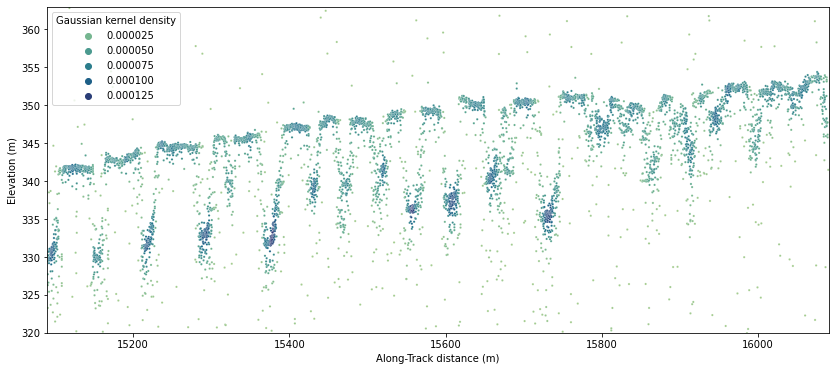

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

sns.scatterplot(x=x, y=y, s=5, hue=kde, palette='crest', ax=ax)
# sns.scatterplot(x=x[kde > 0.0001], y=y[kde > 0.0001], s=5, color='r', ax=ax)
# sns.kdeplot(x=x[q == 4], y=y[q == 4], levels=2, color=".15", linewidths=1, bw_method=0.007, ax=ax)

ax.set_xlim(15090, 16090)
ax.set_ylim(320, 363)
ax.set_xlabel('Along-Track distance (m)')
ax.set_ylabel('Elevation (m)')
ax.legend(title="Gaussian kernel density")

This perceptually uniform color map (`crest`) highlights the bottom of the crevasses with dark colors. It saves us a lot of time find the right way to convey our results. 

Since this is a toy research workflow, we will stop here but welcome you to explore more. For example, you can uncomment the `sns.kdeplot` command or the other `sns.scatterplot` in the above cell and see what will change. You can also try to curve fit the ice surface and plot it on the same figure. This cell will serve as the entry point whenever you need to update the figure.

### Make web map and plot geospatial data

Compared to a traditional map, a web map provides much more ample room to explore the data because the map scale and boundary are not fixed. As its name suggests, a web map can also be easily embedded on a web page along with information such as caption and other figures. The `ipyleaflet` tool makes Jupyter Notebook able to make and display such a map. In our case, we also need `pandas` and `geopandas` to help prepare the ipyleaflet-readable data.

In [68]:
import ipyleaflet as ilfl
import pandas as pd
import geopandas as gpd

To begin, we have to translate necessary information stored as the `xarray.DataArray` to the `geopandas.DataFrame` object. We only select points with `kde > 0.0001` to avoid too many points being plotted and highlight crevasse locations.

In [149]:
# Translate lat, lon, h, and kde into Pandas Series
kde_series = kde[kde > 0.0001].to_series()
h_series   = y[kde > 0.0001].to_series()
lat_series = results.loc['lat'][kde > 0.0001].to_series()
lon_series = results.loc['lon'][kde > 0.0001].to_series()

# Concatenate Series to Pandas DataFrame, and then convert it to Geopandas DataFrame
results_pd = pd.concat([lat_series, lon_series, h_series, kde_series], axis=1, keys=["lat", "lon", "elev", "kde"])
results_gpd = gpd.GeoDataFrame(results_pd, geometry=gpd.points_from_xy(results_pd['lon'], results_pd['lat']), crs='EPSG:4326')
results_gpd

,lat,lon,elev,kde,geometry
dist_alongtrack,,,,,
15094.237983,78.632799,18.341878,330.312836,0.000103,POINT (18.34188 78.63280)
15094.236413,78.632799,18.341878,330.583557,0.000102,POINT (18.34188 78.63280)
15094.237590,78.632799,18.341878,330.367828,0.000103,POINT (18.34188 78.63280)
15094.240338,78.632799,18.341878,329.816895,0.000100,POINT (18.34188 78.63280)
15094.947009,78.632805,18.341872,330.744446,0.000107,POINT (18.34187 78.63281)
...,...,...,...,...,...
15961.124685,78.640419,18.334298,351.996979,0.000103,POINT (18.33430 78.64042)
15961.123505,78.640419,18.334298,352.216827,0.000102,POINT (18.33430 78.64042)
15961.839789,78.640425,18.334292,352.051514,0.000102,POINT (18.33429 78.64043)


Using `ipyleaflet.Map` and `ipyleaflet.GeoData` classes, now we can plot crevasse locations (points with `kde > 0.0001`) on a web map:

In [150]:
zoom = 9                                                               # initial zoom level
center = [float(results.loc['lat'][0]), float(results.loc['lon'][0])]  # initial map center

# Generate leaflet map 
m = ilfl.Map(basemap=ilfl.basemaps.Esri.WorldImagery, center=center, zoom=zoom)
# Generate and add GeoData on the map
geo_data = ilfl.GeoData(geo_dataframe = results_gpd,
    style={'color': '#00203f', 'radius':5},
    point_style={'fillColor': '#adefd1'})
m.add_layer(geo_data)

m

Map(center=[78.63275820720929, 18.341771562786278], controls=(ZoomControl(options=['position', 'zoom_in_text',…

You can furthur zoom in, separate the points, and compare crevass distributions from our results with the crevasses seen on the base satellite map.

```{admonition} Summary
We work with advanced plotting and web map tools to generate figures or html panels with publication quality.
```